Estimate the Sri Lankan government bond yield curve using the Nelson–Siegel model framework

Test sample shapes: (1920, 11) (1920, 3)


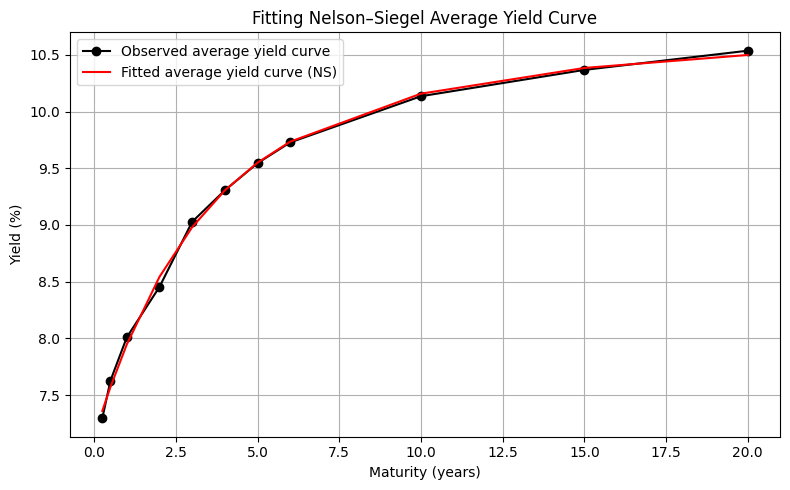

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
FILE_PATH = "DATA.csv"
DATE_COL = "Date"

#  Yield columns
YIELD_COLS = ["3M", "6M", "1Y", "2Y", "3Y",
              "4Y", "5Y", "6Y", "10Y", "15Y", "20Y"]

# Maturities in years
MATURITIES_YEARS = np.array([
    0.25, 0.5, 1.0, 2.0, 3.0,
    4.0, 5.0, 6.0, 10.0, 15.0, 20.0
], dtype=float)

NS_TAU = 1.5

df = pd.read_csv(FILE_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=True)
df = df.sort_values(DATE_COL).set_index(DATE_COL)

df_yields = df[YIELD_COLS].astype(float).interpolate(method="time")

#  Nelson–Siegel functions

def ns_loadings(maturities, tau):
    x = maturities / tau
    x = np.where(x == 0, 1e-6, x)
    L1 = (1 - np.exp(-x)) / x
    L2 = L1 - np.exp(-x)
    return L1, L2

def estimate_ns_betas_row(yields_row, maturities, tau):
    y = np.array(yields_row, dtype=float)
    mask = ~np.isnan(y)
    y = y[mask]
    m = maturities[mask]
    if len(y) < 3:
        return np.array([np.nan, np.nan, np.nan])
    L1, L2 = ns_loadings(m, tau)
    L1, L2 = L1[mask], L2[mask]
    X = np.column_stack([np.ones_like(m), L1, L2])
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    return beta  # beta0, beta1, beta2

def estimate_ns_betas(df_y, maturities, tau):
    betas = []
    for _, row in df_y.iterrows():
        betas.append(estimate_ns_betas_row(row.values, maturities, tau))
    betas = np.array(betas)
    df_b = pd.DataFrame(
        betas, index=df_y.index,
        columns=["beta0", "beta1", "beta2"]
    )
    return df_b

def reconstruct_ns_curve(betas, maturities, tau):
    beta0, beta1, beta2 = betas
    L1, L2 = ns_loadings(maturities, tau)
    return beta0 + beta1 * L1 + beta2 * L2

#  Estimate NS betas for full sample
df_betas = estimate_ns_betas(df_yields, MATURITIES_YEARS, NS_TAU).dropna()

# Align indices
common_idx = df_yields.index.intersection(df_betas.index)
df_yields = df_yields.loc[common_idx]
df_betas  = df_betas.loc[common_idx]

# Restrict to testing period
TEST_START = "2014-01-01"
TEST_END   = "2021-12-31"

yields_test = df_yields.loc[TEST_START:TEST_END, YIELD_COLS]
betas_test  = df_betas.loc[TEST_START:TEST_END, ["beta0", "beta1", "beta2"]]

print("Test sample shapes:", yields_test.shape, betas_test.shape)

# Compute fitted NS yields for test period
fitted_list = []
for _, row in betas_test.iterrows():
    betas_vec = row.values.astype(float)
    y_fit = reconstruct_ns_curve(betas_vec, MATURITIES_YEARS, NS_TAU)
    fitted_list.append(y_fit)

fitted_test = pd.DataFrame(
    fitted_list,
    index=betas_test.index,
    columns=YIELD_COLS
)

# Average observed and fitted curves
obs_avg = yields_test.mean(axis=0)   # observed average per maturity
fit_avg = fitted_test.mean(axis=0)   # fitted average per maturity

# Plot the curve for the testing period.
x = MATURITIES_YEARS

plt.figure(figsize=(8, 5))
plt.plot(x, obs_avg.values,
         marker='o', linestyle='-', color='black',
         label='Observed average yield curve')
plt.plot(x, fit_avg.values,
         linestyle='-', color='red',
         label='Fitted average yield curve (NS)')

plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title("Fitting Nelson–Siegel Average Yield Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The Coefficient of Determination R^2

In [ ]:
import numpy as np
import pandas as pd

# 1. Daily RMSE and MAE across maturities
sq_err = (fitted_test - yields_test) ** 2
abs_err = (fitted_test - yields_test).abs()

rmse_daily = np.sqrt(sq_err.mean(axis=1))   # one RMSE per day
mae_daily  = abs_err.mean(axis=1)          # one MAE per day

# Average fit over testing period
rmse_mean = rmse_daily.mean()
mae_mean  = mae_daily.mean()

print("Average cross-sectional RMSE:", rmse_mean)
print("Average cross-sectional MAE :", mae_mean)

# 2. Cross-sectional R^2 per day
y_bar = yields_test.mean(axis=1)
ss_res = sq_err.sum(axis=1)
ss_tot = ((yields_test.sub(y_bar, axis=0)) ** 2).sum(axis=1)
r2_daily = 1 - ss_res / ss_tot

r2_mean = r2_daily.mean()
print("Average cross-sectional R^2:", r2_mean)


Average cross-sectional RMSE: 0.1333271806282729
Average cross-sectional MAE : 0.10548840299258272
Average cross-sectional R^2: 0.981192298114027
